## Overview
This colab demonstrates the steps to run a family of DeepLab models built by the DeepLab2 library to perform dense pixel labeling tasks. The models used in this colab perform panoptic segmentation, where the predicted value encodes both semantic class and instance label for every pixel (including both ‘thing’ and ‘stuff’ pixels).

### About DeepLab2
DeepLab2 is a TensorFlow library for deep labeling, aiming to facilitate future research on dense pixel labeling tasks by providing state-of-the-art and easy-to-use TensorFlow models. Code is made publicly available at https://github.com/google-research/deeplab2

The checkpoints used in this demo are pretrained on the Cityscapes dataset.

### Import and helper methods

In [1]:
import collections
import os
import tempfile

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import urllib
import cv2

import tensorflow as tf

# from google.colab import files

2023-04-15 19:08:42.846464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 19:08:46.347185: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ernie/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-10.1/lib64:/home/ernie/RealSense_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/local/cuda-10.1/lib64:/opt/ros/noetic/lib/x86_64-linux-gnu
2023-04-15 19:08:46.347220: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cu

In [11]:
DatasetInfo = collections.namedtuple(
    'DatasetInfo',
    'num_classes, label_divisor, thing_list, colormap, class_names')


def _cityscapes_label_colormap():
  """Creates a label colormap used in CITYSCAPES segmentation benchmark.

  See more about CITYSCAPES dataset at https://www.cityscapes-dataset.com/
  M. Cordts, et al. "The Cityscapes Dataset for Semantic Urban Scene Understanding." CVPR. 2016.

  Returns:
    A 2-D numpy array with each row being mapped RGB color (in uint8 range).
  """
  colormap = np.zeros((256, 3), dtype=np.uint8)
  colormap[0] = [128, 64, 128]
  colormap[1] = [244, 35, 232]
  colormap[2] = [70, 70, 70]
  colormap[3] = [102, 102, 156]
  colormap[4] = [190, 153, 153]
  colormap[5] = [153, 153, 153]
  colormap[6] = [250, 170, 30]
  colormap[7] = [220, 220, 0]
  colormap[8] = [107, 142, 35]
  colormap[9] = [152, 251, 152]
  colormap[10] = [70, 130, 180]
  colormap[11] = [220, 20, 60]
  colormap[12] = [255, 0, 0]
  colormap[13] = [0, 0, 142]
  colormap[14] = [0, 0, 70]
  colormap[15] = [0, 60, 100]
  colormap[16] = [0, 80, 100]
  colormap[17] = [0, 0, 230]
  colormap[18] = [119, 11, 32]
  return colormap


def _cityscapes_class_names():
  return ('road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
          'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
          'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
          'bicycle')


def cityscapes_dataset_information():
  return DatasetInfo(
      num_classes=19,
      label_divisor=1000,
      thing_list=tuple(range(11, 19)),
      colormap=_cityscapes_label_colormap(),
      class_names=_cityscapes_class_names())


def perturb_color(color, noise, used_colors, max_trials=50, random_state=None):
  """Pertrubs the color with some noise.

  If `used_colors` is not None, we will return the color that has
  not appeared before in it.

  Args:
    color: A numpy array with three elements [R, G, B].
    noise: Integer, specifying the amount of perturbing noise (in uint8 range).
    used_colors: A set, used to keep track of used colors.
    max_trials: An integer, maximum trials to generate random color.
    random_state: An optional np.random.RandomState. If passed, will be used to
      generate random numbers.

  Returns:
    A perturbed color that has not appeared in used_colors.
  """
  if random_state is None:
    random_state = np.random

  for _ in range(max_trials):
    random_color = color + random_state.randint(
        low=-noise, high=noise + 1, size=3)
    # random_color = color
    random_color = np.clip(random_color, 0, 255)

    if tuple(random_color) not in used_colors:
      used_colors.add(tuple(random_color))
      return random_color

  print('Max trial reached and duplicate color will be used. Please consider '
        'increase noise in `perturb_color()`.')
  return random_color


def color_panoptic_map(panoptic_prediction, dataset_info, perturb_noise):
  """Helper method to colorize output panoptic map.

  Args:
    panoptic_prediction: A 2D numpy array, panoptic prediction from deeplab
      model.
    dataset_info: A DatasetInfo object, dataset associated to the model.
    perturb_noise: Integer, the amount of noise (in uint8 range) added to each
      instance of the same semantic class.

  Returns:
    colored_panoptic_map: A 3D numpy array with last dimension of 3, colored
      panoptic prediction map.
    used_colors: A dictionary mapping semantic_ids to a set of colors used
      in `colored_panoptic_map`.
  """
  if panoptic_prediction.ndim != 2:
    raise ValueError('Expect 2-D panoptic prediction. Got {}'.format(
        panoptic_prediction.shape))

  semantic_map = panoptic_prediction // dataset_info.label_divisor
  instance_map = panoptic_prediction % dataset_info.label_divisor
  height, width = panoptic_prediction.shape
  colored_panoptic_map = np.zeros((height, width, 3), dtype=np.uint8)

  used_colors = collections.defaultdict(set)
  # Use a fixed seed to reproduce the same visualization.
  random_state = np.random.RandomState(0)

  unique_semantic_ids = np.unique(semantic_map)
  for semantic_id in unique_semantic_ids:
    semantic_mask = semantic_map == semantic_id
    if semantic_id in dataset_info.thing_list:
      # For `thing` class, we will add a small amount of random noise to its
      # correspondingly predefined semantic segmentation colormap.
      unique_instance_ids = np.unique(instance_map[semantic_mask])
      for instance_id in unique_instance_ids:
        instance_mask = np.logical_and(semantic_mask,
                                       instance_map == instance_id)
        random_color = perturb_color(
            dataset_info.colormap[semantic_id],
            perturb_noise,
            used_colors[semantic_id],
            random_state=random_state)
        colored_panoptic_map[instance_mask] = random_color
    else:
      # For `stuff` class, we use the defined semantic color.
      colored_panoptic_map[semantic_mask] = dataset_info.colormap[semantic_id]
      used_colors[semantic_id].add(tuple(dataset_info.colormap[semantic_id]))
  return colored_panoptic_map, used_colors


def vis_segmentation(image,
                     panoptic_prediction,
                     dataset_info,
                     perturb_noise=60):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(30, 20))
  grid_spec = gridspec.GridSpec(2, 2)

  ax = plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  ax.set_title('input image', fontsize=20)

  ax = plt.subplot(grid_spec[1])
  panoptic_map, used_colors = color_panoptic_map(panoptic_prediction,
                                                 dataset_info, perturb_noise)
  plt.imshow(panoptic_map)
  plt.axis('off')
  ax.set_title('panoptic map', fontsize=20)

  ax = plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(panoptic_map, alpha=0.7)
  plt.axis('off')
  ax.set_title('panoptic overlay', fontsize=20)

  ax = plt.subplot(grid_spec[3])
  max_num_instances = max(len(color) for color in used_colors.values())
  # RGBA image as legend.
  legend = np.zeros((len(used_colors), max_num_instances, 4), dtype=np.uint8)
  class_names = []
  for i, semantic_id in enumerate(sorted(used_colors)):
    legend[i, :len(used_colors[semantic_id]), :3] = np.array(
        list(used_colors[semantic_id]))
    legend[i, :len(used_colors[semantic_id]), 3] = 255
    if semantic_id < dataset_info.num_classes:
      class_names.append(dataset_info.class_names[semantic_id])
    else:
      class_names.append('ignore')

  plt.imshow(legend, interpolation='nearest')
  ax.yaxis.tick_left()
  plt.yticks(range(len(legend)), class_names, fontsize=15)
  plt.xticks([], [])
  ax.tick_params(width=0.0, grid_linewidth=0.0)
  plt.grid('off')
  plt.show()

### Select a pretrained model

In [3]:
MODEL_NAME = 'resnet50_kmax_deeplab_cityscapes_train'  # @param ['resnet50_os32_panoptic_deeplab_cityscapes_crowd_trainfine_saved_model', 'resnet50_beta_os32_panoptic_deeplab_cityscapes_trainfine_saved_model', 'wide_resnet41_os16_panoptic_deeplab_cityscapes_trainfine_saved_model', 'swidernet_sac_1_1_1_os16_panoptic_deeplab_cityscapes_trainfine_saved_model', 'swidernet_sac_1_1_3_os16_panoptic_deeplab_cityscapes_trainfine_saved_model', 'swidernet_sac_1_1_4.5_os16_panoptic_deeplab_cityscapes_trainfine_saved_model', 'axial_swidernet_1_1_1_os16_axial_deeplab_cityscapes_trainfine_saved_model', 'axial_swidernet_1_1_3_os16_axial_deeplab_cityscapes_trainfine_saved_model', 'axial_swidernet_1_1_4.5_os16_axial_deeplab_cityscapes_trainfine_saved_model', 'max_deeplab_s_backbone_os16_axial_deeplab_cityscapes_trainfine_saved_model', 'max_deeplab_l_backbone_os16_axial_deeplab_cityscapes_trainfine_saved_model', 'resnet50_kmax_deeplab_cityscapes_train','axial_resnet50_kmax_deeplab_cityscapes_train','convnext_tiny_kmax_deeplab_cityscapes_train','convnext_small_kmax_deeplab_cityscapes_train','convnext_base_kmax_deeplab_cityscapes_train','convnext_large_kmax_deeplab_cityscapes_train']


_MODELS = ('resnet50_os32_panoptic_deeplab_cityscapes_crowd_trainfine_saved_model',
           'resnet50_beta_os32_panoptic_deeplab_cityscapes_trainfine_saved_model',
           'wide_resnet41_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
           'swidernet_sac_1_1_1_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
           'swidernet_sac_1_1_3_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
           'swidernet_sac_1_1_4.5_os16_panoptic_deeplab_cityscapes_trainfine_saved_model',
           'axial_swidernet_1_1_1_os16_axial_deeplab_cityscapes_trainfine_saved_model',
           'axial_swidernet_1_1_3_os16_axial_deeplab_cityscapes_trainfine_saved_model',
           'axial_swidernet_1_1_4.5_os16_axial_deeplab_cityscapes_trainfine_saved_model',
           'max_deeplab_s_backbone_os16_axial_deeplab_cityscapes_trainfine_saved_model',
           'max_deeplab_l_backbone_os16_axial_deeplab_cityscapes_trainfine_saved_model',
           'resnet50_kmax_deeplab_cityscapes_train',
           'axial_resnet50_kmax_deeplab_cityscapes_train',
           'convnext_tiny_kmax_deeplab_cityscapes_train',
           'convnext_small_kmax_deeplab_cityscapes_train',
           'convnext_base_kmax_deeplab_cityscapes_train',
           'convnext_large_kmax_deeplab_cityscapes_train',)
_DOWNLOAD_URL_PATTERN = 'https://storage.googleapis.com/gresearch/tf-deeplab/saved_model/%s.tar.gz'

_MODEL_NAME_TO_URL_AND_DATASET = {
    model: (_DOWNLOAD_URL_PATTERN % model, cityscapes_dataset_information())
    for model in _MODELS
}

MODEL_URL, DATASET_INFO = _MODEL_NAME_TO_URL_AND_DATASET[MODEL_NAME]


In [4]:
# model_dir = tempfile.mkdtemp()
model_dir = os.getcwd()

download_path = os.path.join(model_dir, MODEL_NAME + '.gz')
# urllib.request.urlretrieve(MODEL_URL, download_path)

# !tar -xzvf {download_path} -C {model_dir}

LOADED_MODEL = tf.saved_model.load(os.path.join(model_dir, MODEL_NAME))

2023-04-15 19:09:18.602167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 19:09:18.602537: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ernie/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-10.1/lib64:/home/ernie/RealSense_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/local/cuda-10.1/lib64:/opt/ros/noetic/lib/x86_64-linux-gnu
2023-04-15 19:09:18.602635: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No su

### Run on sample images

In [13]:
# Required, upload an image from your local machine.

# uploaded = files.upload()

# if not uploaded:
#   raise AssertionError('Please upload one image')
# elif len(uploaded) == 1:
#   UPLOADED_FILE = list(uploaded.keys())[0]
# else:
#   raise AssertionError('Please upload one image at a time')
# UPLOADED_FILE = 'LA_7.png'
UPLOADED_FILE = './data/Frames_FRONT.png'

Max trial reached and duplicate color will be used. Please consider increase noise in `perturb_color()`.
Max trial reached and duplicate color will be used. Please consider increase noise in `perturb_color()`.
Max trial reached and duplicate color will be used. Please consider increase noise in `perturb_color()`.
Max trial reached and duplicate color will be used. Please consider increase noise in `perturb_color()`.
Max trial reached and duplicate color will be used. Please consider increase noise in `perturb_color()`.
Max trial reached and duplicate color will be used. Please consider increase noise in `perturb_color()`.
Max trial reached and duplicate color will be used. Please consider increase noise in `perturb_color()`.
Max trial reached and duplicate color will be used. Please consider increase noise in `perturb_color()`.
Max trial reached and duplicate color will be used. Please consider increase noise in `perturb_color()`.
Max trial reached and duplicate color will be used. Ple

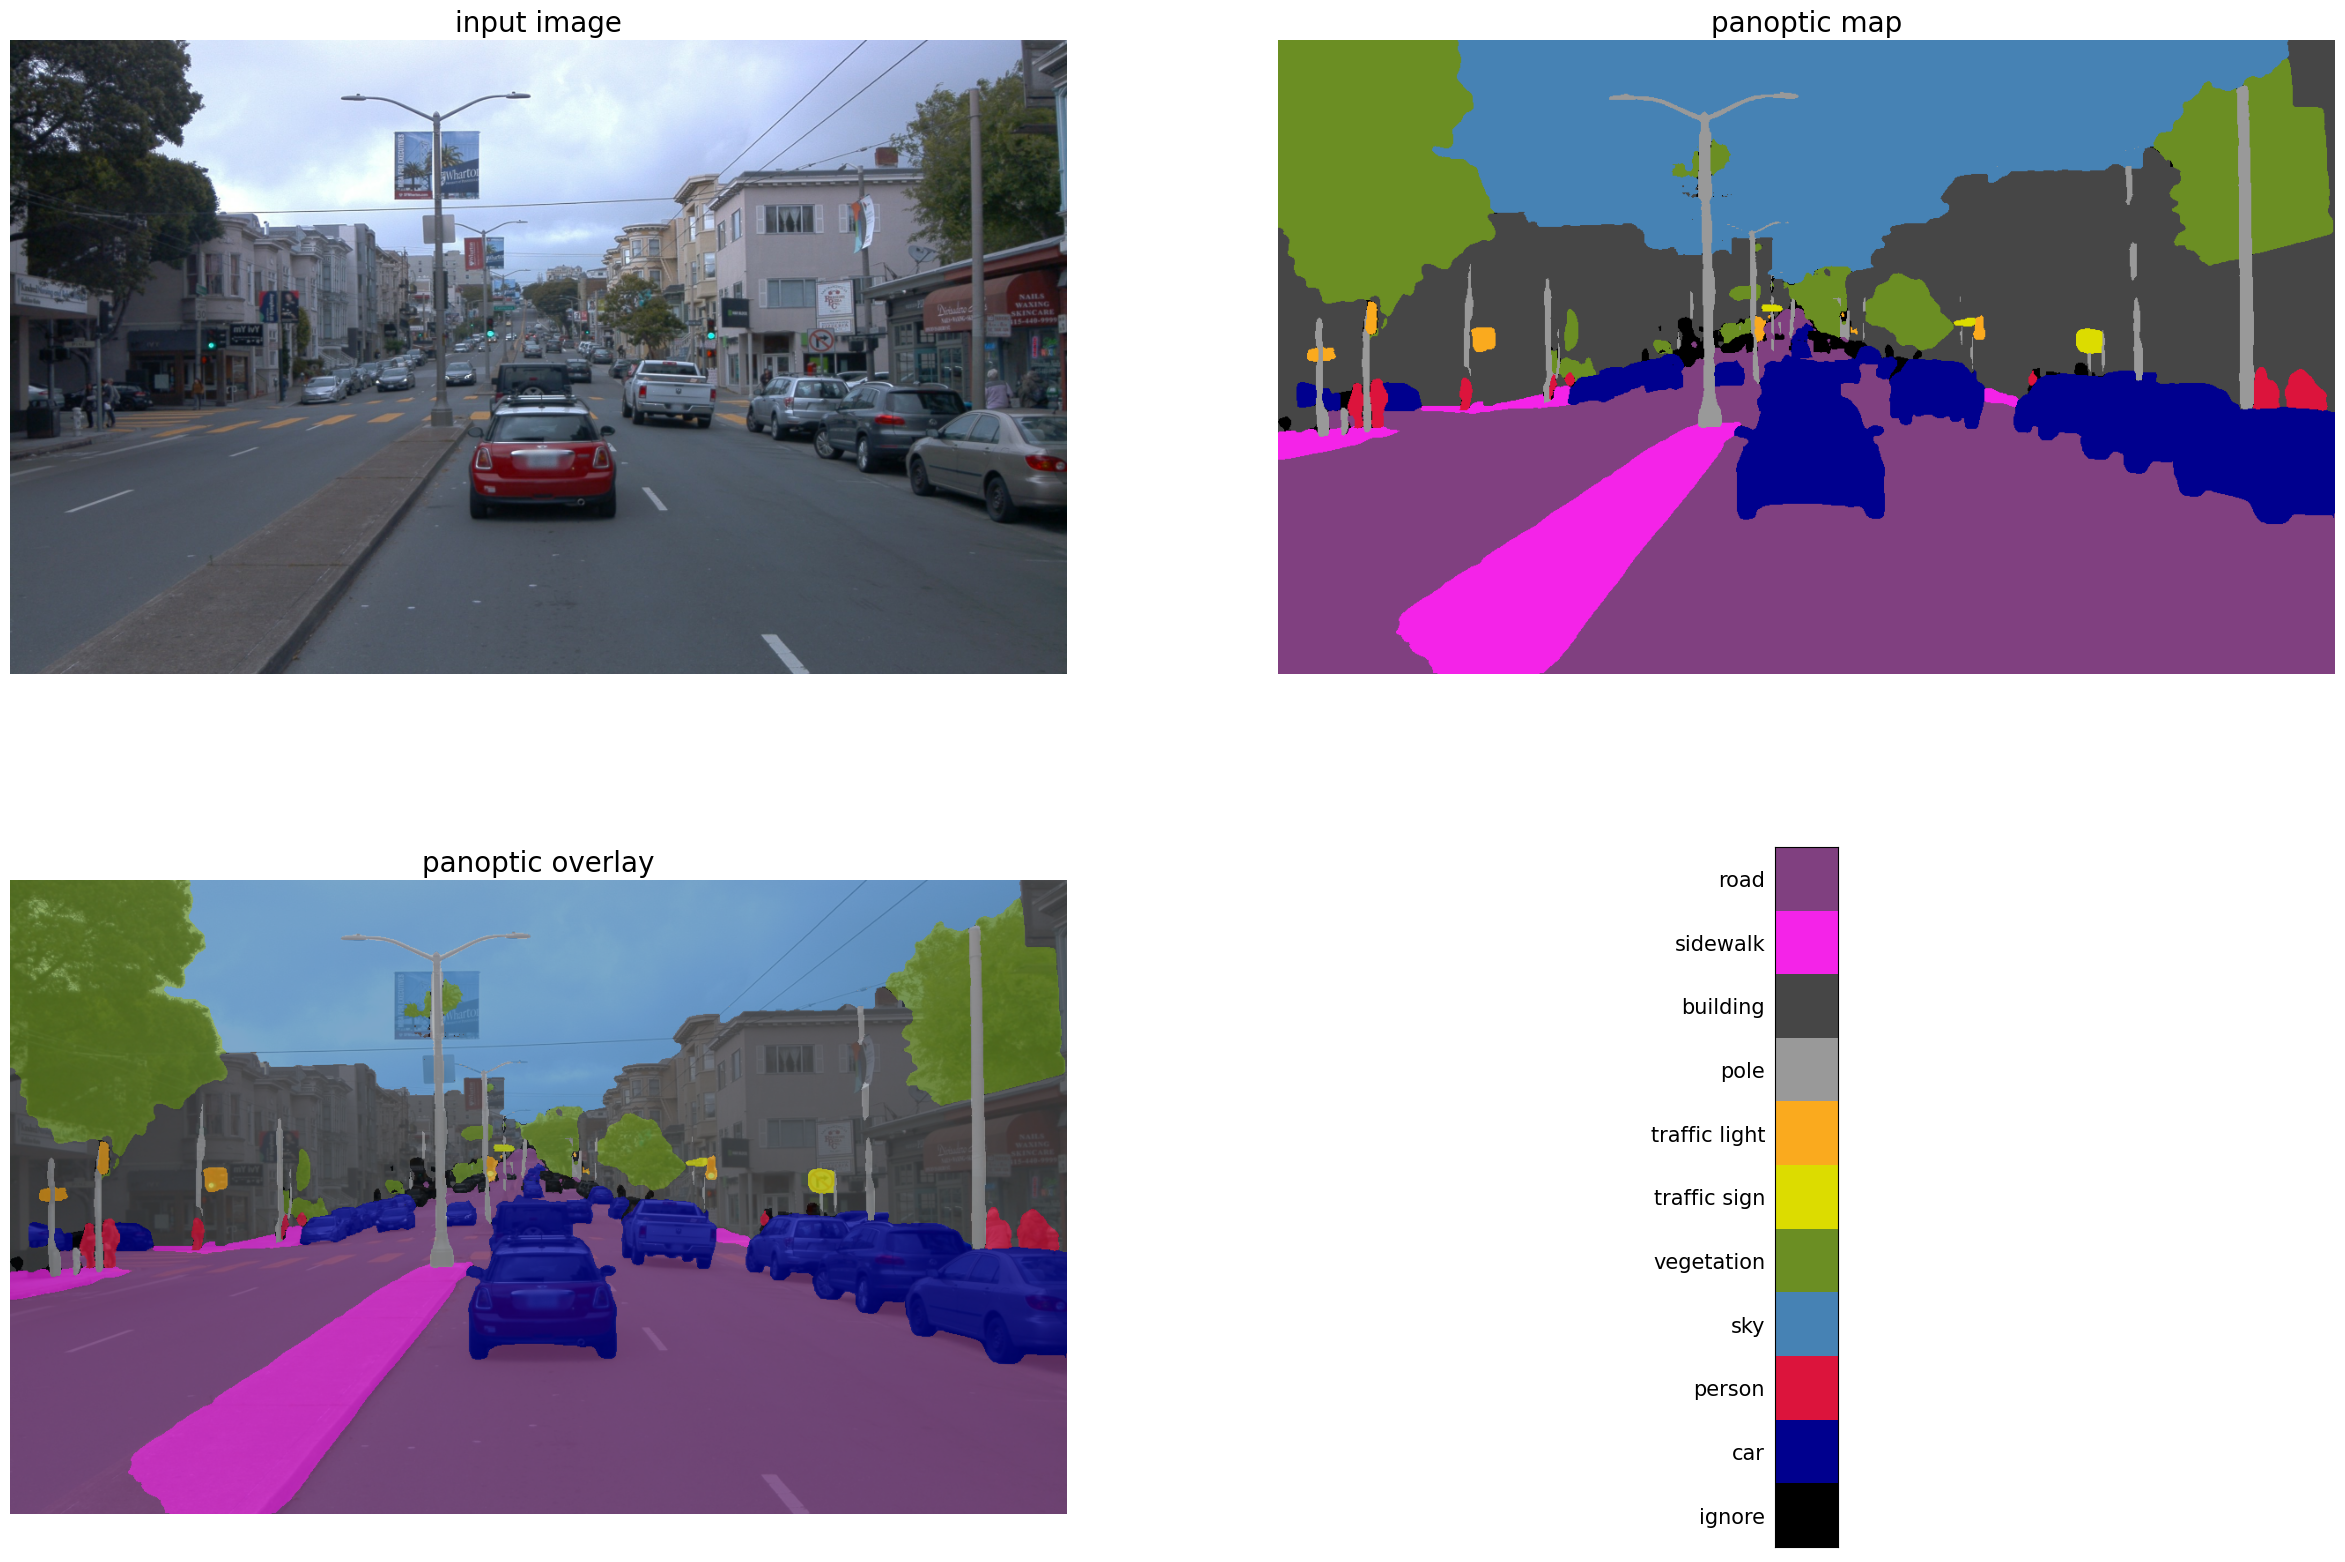

In [14]:
# with tf.io.gfile.GFile(UPLOADED_FILE, 'rb') as f:
# im = np.array(Image.open(f))

im = cv2.imread(UPLOADED_FILE)
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
im = cv2.resize(im, (1200, 720), interpolation=cv2.INTER_LINEAR)
# output = LOADED_MODEL(tf.cast(im, tf.uint8))
# # print(output)
# vis_segmentation(im, output['panoptic_pred'][0], DATASET_INFO, UPLOADED_FILE)